In [1]:
import tensorflow as tf

In [2]:
import cv2
import os
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
    
print(tf.test.gpu_device_name())

/device:GPU:0


In [4]:
images = tf.data.Dataset.list_files('data/train/images/*.jpg', shuffle=False)

In [5]:
images.as_numpy_iterator().next()

b'data\\train\\images\\98457312-6033-11ee-b611-00919e566e77.jpg'

In [4]:
def load_img(x):
    bimg = tf.io.read_file(x)
    img = tf.io.decode_jpeg(bimg)
    return img

In [7]:
images = images.map(load_img)
images.as_numpy_iterator().next()

array([[[111,  82,  66],
        [114,  85,  67],
        [110,  81,  63],
        ...,
        [ 77,  76,  81],
        [ 78,  77,  85],
        [ 74,  73,  81]],

       [[115,  86,  70],
        [118,  89,  71],
        [113,  85,  64],
        ...,
        [ 78,  77,  83],
        [ 81,  80,  88],
        [ 81,  80,  88]],

       [[112,  83,  65],
        [114,  85,  67],
        [112,  84,  63],
        ...,
        [ 78,  77,  83],
        [ 80,  79,  87],
        [ 83,  81,  92]],

       ...,

       [[ 31,  14,  20],
        [ 31,  14,  20],
        [ 31,  14,  20],
        ...,
        [ 34,  31,  38],
        [ 32,  29,  36],
        [ 32,  29,  36]],

       [[ 31,  16,  21],
        [ 30,  15,  20],
        [ 29,  14,  19],
        ...,
        [ 31,  28,  35],
        [ 29,  26,  33],
        [ 27,  24,  31]],

       [[ 30,  15,  20],
        [ 29,  14,  19],
        [ 28,  13,  18],
        ...,
        [ 31,  28,  35],
        [ 28,  25,  32],
        [ 27,  24,  31]]

In [8]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [9]:

#Visualise
img_generator = images.batch(4).as_numpy_iterator()

In [10]:
plot_images = img_generator.next()

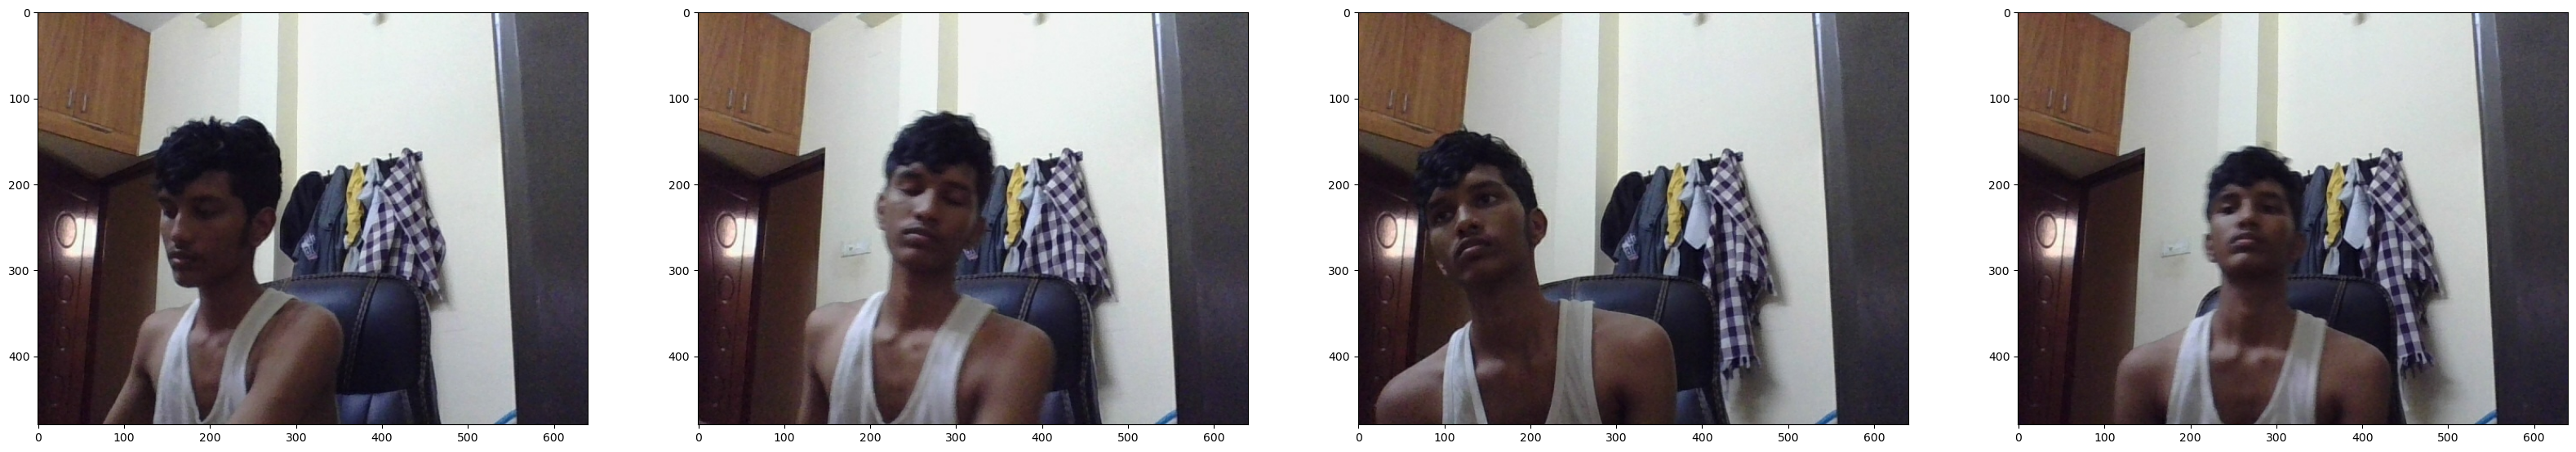

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(40,40))
for idx,img in enumerate(plot_images):
    ax[idx].imshow(img)
plt.show()

# Partitioning Data
Train : 70% or 63 images
Test : 15% or 14 images
Validation : 15% or 13 images
Image split in split_data.py


In [13]:
#Moving labels
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath,new_filepath)

Albumentation Transform Pipeline

In [4]:
import albumentations as alb

In [5]:
augmentor = alb.Compose([alb.RandomCrop(width=450,height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations',
                           label_fields=['class_labels']))

In [6]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                # noinspection PyDictCreation
                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

KeyboardInterrupt: 

In [5]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_img)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [6]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_img)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [7]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_img)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [8]:
train_images.as_numpy_iterator().next()

array([[[0.11427696, 0.1033701 , 0.15294118],
        [0.12659314, 0.11813726, 0.16648284],
        [0.12401961, 0.10833333, 0.16323529],
        ...,
        [0.20765932, 0.1331495 , 0.11746324],
        [0.22156863, 0.14313726, 0.1392157 ],
        [0.20686275, 0.12843138, 0.13480392]],

       [[0.11911765, 0.11470588, 0.14754902],
        [0.12542892, 0.11758579, 0.16072305],
        [0.11078431, 0.10343137, 0.14509805],
        ...,
        [0.23088235, 0.15637255, 0.14068627],
        [0.2322304 , 0.1547794 , 0.1502451 ],
        [0.21893382, 0.14577205, 0.14411765]],

       [[0.11832108, 0.10833333, 0.16966912],
        [0.1302696 , 0.12242647, 0.17242648],
        [0.12506127, 0.12113971, 0.14650735],
        ...,
        [0.22702205, 0.15251225, 0.13682598],
        [0.22107843, 0.15      , 0.14117648],
        [0.22224265, 0.1516544 , 0.13952206]],

       ...,

       [[0.28259805, 0.27083334, 0.30122548],
        [0.28180146, 0.2661152 , 0.32150736],
        [0.27089462, 0

Prepare Labels

In [9]:
def load_labels(label_path):
    with open(label_path.numpy(),'r',encoding='utf-8') as f:
        label = json.load(f)
    return [label['class']],label['bbox']

In [10]:

train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json',shuffle=False)
train_labels = train_labels.map(lambda x:tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [11]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.8047, 0.3025, 1.    , 0.73  ], dtype=float16))

In [12]:

test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [13]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

Combining and making final dataset

In [14]:
train = tf.data.Dataset.zip((train_images, train_labels)) #Combine image and labels
train = train.shuffle(5000) #Shuffling images
train = train.batch(8) #Batch size 8
train = train.prefetch(4) 

In [15]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [16]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [17]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[7.358e-01, 3.225e-01, 1.000e+00, 8.838e-01],
        [8.374e-01, 4.670e-01, 1.000e+00, 7.935e-01],
        [0.000e+00, 8.826e-02, 2.408e-01, 6.284e-01],
        [2.487e-01, 2.126e-01, 5.962e-01, 5.781e-01],
        [2.859e-01, 1.654e-01, 5.464e-01, 5.239e-01],
        [8.159e-04, 3.589e-01, 2.976e-01, 8.120e-01],
        [4.382e-01, 3.608e-01, 8.335e-01, 7.251e-01],
        [2.322e-01, 4.443e-01, 6.880e-01, 9.941e-01]], dtype=float16))

In [55]:
data_s = train.as_numpy_iterator()

In [65]:
res = data_s.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


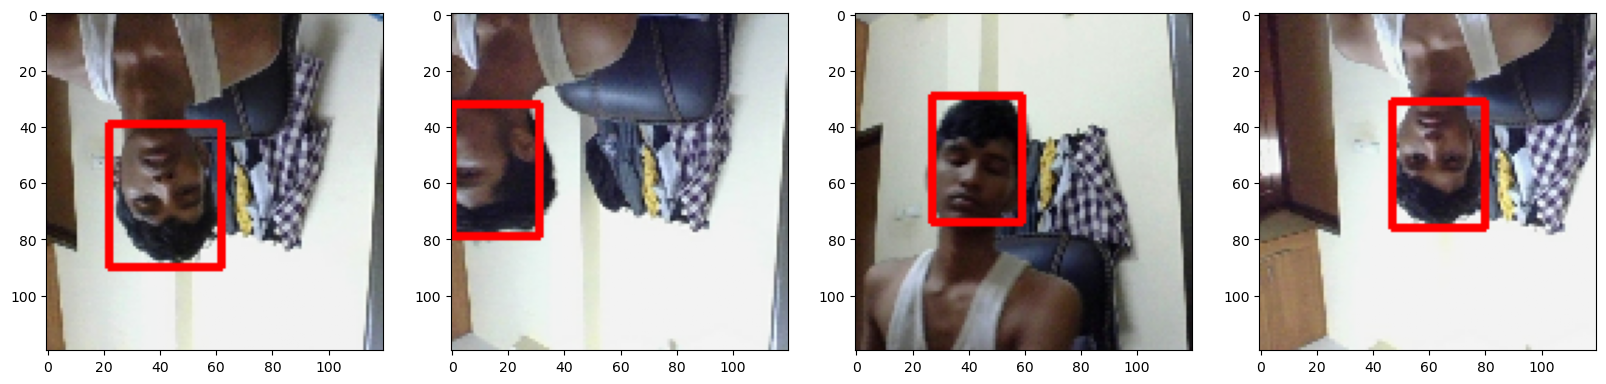

In [66]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [50]:

#The data preprocessing is over

Neural Network

In [18]:
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from keras.applications.vgg16 import VGG16

In [19]:
vgg = VGG16(include_top=False)

In [20]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [21]:
def build_model():
    input_layer = Input(shape=(120,120,3))
    vgg = VGG16(include_top=False)(input_layer)
    
    #classification model
    m1 = GlobalMaxPooling2D()(vgg)
    l1 = Dense(2048, activation='relu')(m1)
    l2 = Dense(1, activation='sigmoid')(l1)
    
    #regresstion model ie bounding box
    m2 = GlobalMaxPooling2D()(vgg)
    r1 = Dense(2048, activation='relu')(m2)
    r2 = Dense(4, activation='sigmoid')(r1)
    
    detect = Model(inputs = input_layer, outputs = [l2,r2])
    return detect

In [22]:
facedetect = build_model()

In [23]:
facedetect.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [24]:
len(train)

473

In [25]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001,decay=lr_decay)

In [27]:
def localization_loss(y_true,yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true-w_pred) +  tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [28]:
closs = tf.keras.losses.BinaryCrossentropy()
rloss = localization_loss

In [29]:

class FaceDetect(Model): 
    def __init__(self, tracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = tracker

    def compile(self, optimizer, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.optimizer = optimizer
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        optimizer.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [85]:
model = FaceDetect(facedetect)
model.compile(optimizer,closs,rloss)
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
473/473 [==============================] - 37s 69ms/step - total_loss: 0.2831 - class_loss: 0.0698 - regress_loss: 0.2482 - val_total_loss: 0.1439 - val_class_loss: 6.4242e-04 - val_regress_loss: 0.1436
Epoch 2/40
473/473 [==============================] - 34s 64ms/step - total_loss: 0.0775 - class_loss: 0.0202 - regress_loss: 0.0674 - val_total_loss: 1.3861 - val_class_loss: 0.5987 - val_regress_loss: 1.0868
Epoch 3/40
473/473 [==============================] - 33s 65ms/step - total_loss: 0.0340 - class_loss: 0.0081 - regress_loss: 0.0299 - val_total_loss: 0.0456 - val_class_loss: 3.9159e-04 - val_regress_loss: 0.0454
Epoch 4/40
473/473 [==============================] - 34s 66ms/step - total_loss: 0.0330 - class_loss: 0.0099 - regress_loss: 0.0280 - val_total_loss: 1.6488 - val_class_loss: 1.5521 - val_regress_loss: 0.8727
Epoch 5/40
473/473 [==============================] - 35s 67ms/step - total_loss: 0.0173 - class_loss: 0.0043 - regress_loss: 0.0151 - val_total_loss: 3

In [86]:
hist.history

{'total_loss': [0.069585420191288,
  0.021394338458776474,
  0.004766243044286966,
  0.0027769841253757477,
  0.003348717000335455,
  0.002515045925974846,
  0.0031439901795238256,
  0.0008232444524765015,
  0.002510061487555504,
  0.0032467818818986416,
  0.0006795483059249818,
  0.001513490453362465,
  0.0009708002908155322,
  0.0006561017362400889,
  0.0008093845099210739,
  0.0006929763476364315,
  0.0003159945772495121,
  0.0003949605452362448,
  0.0015911244554445148,
  0.00033136396086774766,
  0.0005735302111133933,
  0.0010225340956822038,
  0.00012630112178158015,
  0.00017712076078169048,
  0.0006007204647175968,
  0.00016200094250962138,
  0.0009838358964771032,
  0.0003561732592061162,
  0.0008062004926614463,
  9.057121496880427e-05,
  0.0005233106203377247,
  0.00022763396555092186,
  0.0009969457751139998,
  0.0002618782746139914,
  0.0001962314563570544,
  4.8926529416348785e-05,
  0.0004899126361124218,
  0.00014712262782268226,
  0.00010315320832887664,
  9.011606744

NameError: name 'hist' is not defined

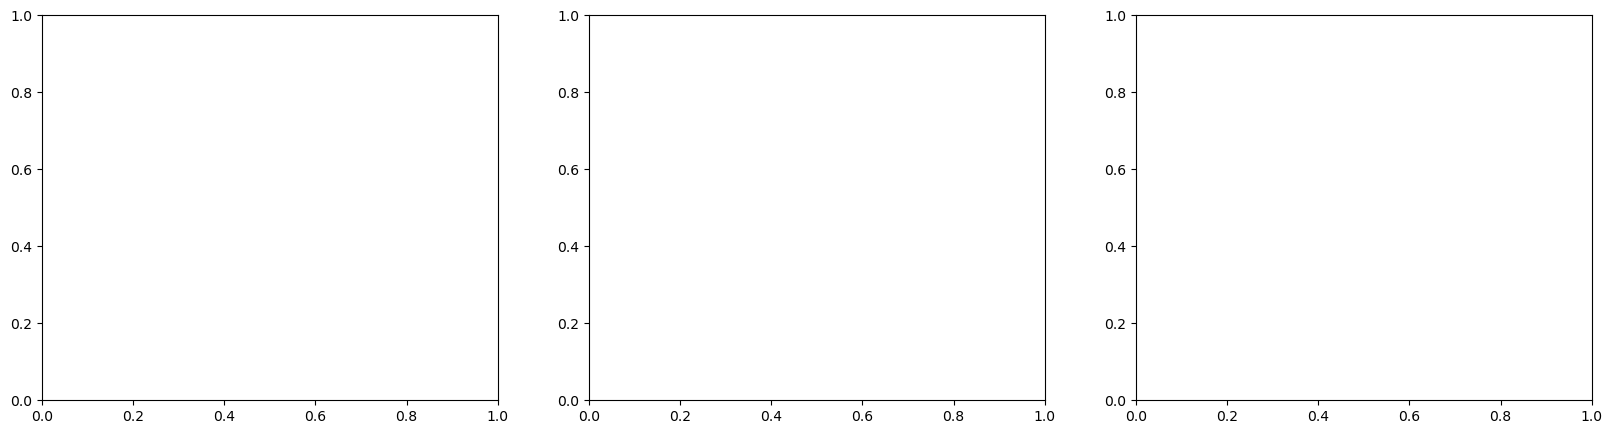

In [30]:

fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [88]:
test_data = test.as_numpy_iterator()

In [89]:

test_sample = test_data.next()

In [90]:
yhat = facedetect.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


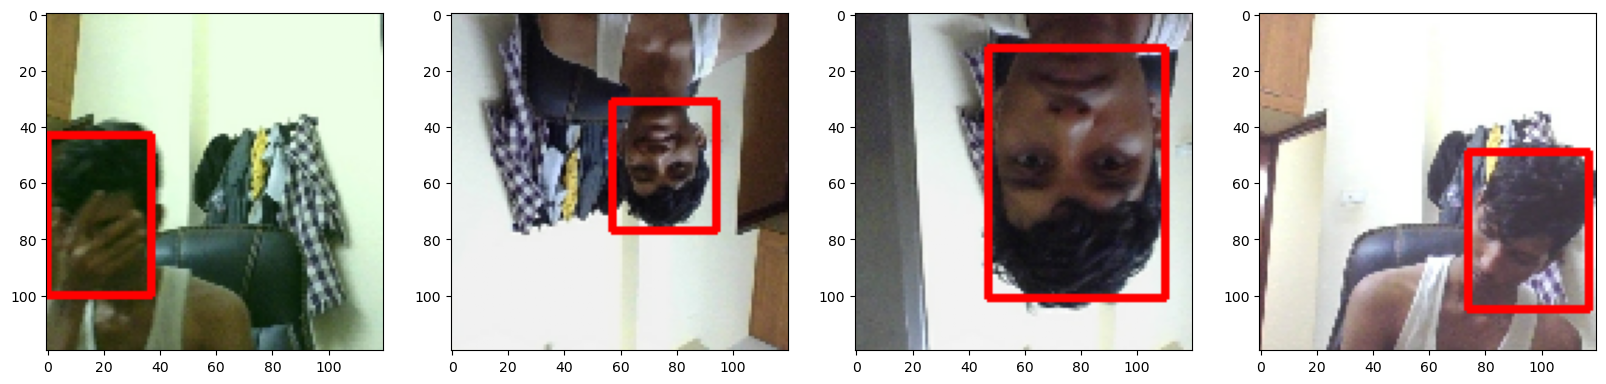

In [91]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [92]:
from keras.models import load_model

In [101]:
facedetect.compile(optimizer,loss=closs)

In [102]:
facedetect.evaluate(train)

473/473 [==============================] - 20s 31ms/step - loss: 0.5136 - dense_5_loss: 3.6926e-07 - dense_7_loss: 0.5136


[0.5135523080825806, 3.6925607105331437e-07, 0.5135519504547119]

In [103]:
facedetect.save('facedetection_model.h5')

In [31]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facedetect.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('FaceDetection', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()